In [ ]:
from plots.plot_utils import load_pickle
example_pkl = "/home/scratch/yixiz/results/test_seeds/boston/test/boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_4.pkl"
baseline_names = ['batch_qr', 'batch_int', 'batch_cal']
seeds = [0, 1, 2, 3, 4]
seed_pkls = [example_pkl.replace("_4", "_{}".format(seed)) for seed in seeds]
print(seed_pkls)
import numpy as np
def get_quantile_seed_idxs(seed_pkls, quantile=0.5):
    datas = [load_pickle(pkl) for pkl in seed_pkls]
    va_sharp_score_thresholded = np.full((5, 150), 1.0)
    for i, data in enumerate(datas):
        va_sharp_score_thresholded[i, -len(data['va_sharp_score_thresholded']):] = data['va_sharp_score_thresholded']

    order = np.argsort(va_sharp_score_thresholded, axis=0)
    q_idx = int(quantile * len(seed_pkls) - 1)
    quantile_seed_idxs = order[q_idx, np.arange(order.shape[1])]
    return quantile_seed_idxs

def aggregate_seeds(seed_pkls, quantile=0.5):
    datas = [load_pickle(pkl) for pkl in seed_pkls]
    
    quantile_seed_idxs = get_quantile_seed_idxs(seed_pkls, quantile)

    te_sharp_score_thresholded = np.full((5, 150), 1.0)
    te_ece_thresholded = np.full((5, 150), 1.0)
    va_sharp_score_thresholded = np.full((5, 150), 1.0)
    va_ece_thresholded = np.full((5, 150), 1.0)
    for i, data in enumerate(datas):
        te_sharp_score_thresholded[i, -len(data['te_sharp_score_thresholded']):] = data['te_sharp_score_thresholded']
        te_ece_thresholded[i, -len(data['te_ece_thresholded']):] = data['te_ece_thresholded']
        va_sharp_score_thresholded[i, -len(data['va_sharp_score_thresholded']):] = data['va_sharp_score_thresholded']
        va_ece_thresholded[i, -len(data['va_ece_thresholded']):] = data['va_ece_thresholded']

    # retrieve test scores based on quantile seed idxs
    threshold_to_test_ece_sharp = {}
    for thres_idx, threshold in enumerate(np.linspace(0.001, 0.15, 150)):
        seed_idx = quantile_seed_idxs[thres_idx]
        te_ece = te_ece_thresholded[seed_idx, thres_idx]
        te_sharp = te_sharp_score_thresholded[seed_idx, thres_idx]
        va_ece = va_ece_thresholded[seed_idx, thres_idx]
        va_sharp = va_sharp_score_thresholded[seed_idx, thres_idx]
        if te_ece == 1.0 and te_sharp == 1.0:
            continue
        threshold_to_test_ece_sharp[float(threshold)] = {'te_ece': float(te_ece), 'te_sharp_score': float(te_sharp),
                                                         'va_ece': float(va_ece), "va_sharp_score": float(va_sharp)}
    
    return threshold_to_test_ece_sharp

import matplotlib.pyplot as plt
def plot_and_compute_mean_deviation(threshold_to_test_ece_sharp, baseline_name, dataset):
    te_ece = [dic['te_ece'] for dic in threshold_to_test_ece_sharp.values()]
    va_ece = [dic['va_ece'] for dic in threshold_to_test_ece_sharp.values()]
    thresholds = list(threshold_to_test_ece_sharp.keys()) 
    below_thres_prop = len([dic['te_ece'] - thres for thres, dic in threshold_to_test_ece_sharp.items() if dic['te_ece'] <= thres]) / float(len(te_ece))
    mean_exceedance = np.mean([dic['te_ece'] - thres for thres, dic in threshold_to_test_ece_sharp.items() if dic['te_ece'] > thres])
    plt.scatter(thresholds, np.maximum(np.array(te_ece) - np.array(thresholds), 0), label=f"{baseline_name}: p-{below_thres_prop:.1%} m-{mean_exceedance:.3f}")
    plt.title(f"{dataset} - p=proportion of below threshold; m=mean exceedance (only counting exceeding points)")
    plt.xlabel('ECE Threshold')
    plt.ylabel('ECE max(Test - Threshold, 0)')
    plt.legend()
    return below_thres_prop, mean_exceedance

In [ ]:
baseline_data = {}
for baseline_name in baseline_names:
    pkl_cal = example_pkl.replace("batch_int", baseline_name)
    seed_pkls = [pkl_cal.replace("_4", "_{}".format(seed)) for seed in seeds]
    baseline_aggregated = aggregate_seeds(seed_pkls, quantile=0.0)
    below_thres_prop, mean_exceedance = plot_and_compute_mean_deviation(baseline_aggregated, baseline_name, "boston")
    print(f"{baseline_name}: {below_thres_prop}, {mean_exceedance}")
    baseline_data[baseline_name] = baseline_aggregated
plt.show()
plt.close()

import matplotlib.pyplot as plt
for baseline_name, baseline_aggregated in baseline_data.items():
    te_ece = [dic['te_ece'] for dic in baseline_aggregated.values()]
    te_sharp = [dic['te_sharp_score'] for dic in baseline_aggregated.values()]
    plt.scatter(te_ece, te_sharp, label=baseline_name)
plt.legend()

In [ ]:
sorted([dic['te_ece'] for dic in threshold_to_test_ece_sharp.values()])

In [ ]:
from plots.plot_utils import load_pickle
from data.fetch_data import get_uci_data
pkl_cal = load_pickle("boston_lossbatch_cal_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl8_hs256_0.pkl")
pkl_int = load_pickle("boston_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl8_hs256_0.pkl")
pkl_qr = load_pickle("boston_lossbatch_qr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl8_hs256_0.pkl")

In [ ]:
print(len(pkl_cal['te_cali_score_controlled']), len(pkl_int['te_cali_score_controlled']), len(pkl_qr['te_cali_score_controlled']))
print(len(pkl_cal['te_ece_controlled']), len(pkl_int['te_ece_controlled']), len(pkl_qr['te_ece_controlled']))
pkl_qr['te_cali_score_controlled']

In [ ]:
import matplotlib.pyplot as plt

plt.plot(pkl_cal['te_ece_controlled'], pkl_cal['te_sharp_score_controlled'])
plt.plot(pkl_int['te_ece_controlled'], pkl_int['te_sharp_score_controlled'])
plt.plot(pkl_qr['te_ece_controlled'], pkl_qr['te_sharp_score_controlled'])
plt.legend(['cal', 'int', 'qr'])
plt.xlabel('Test ECE')

In [ ]:
plt.plot(pkl_qr['recal_te_ece_controlled'], pkl_qr['recal_te_sharp_score_controlled'])
plt.plot(pkl_int['recal_te_ece_controlled'], pkl_int['recal_te_sharp_score_controlled'])
plt.plot(pkl_cal['recal_te_ece_controlled'], pkl_cal['recal_te_sharp_score_controlled'])
plt.legend(['qr', 'int', 'cal'])
plt.xlabel('Recalibrated Test ECE')

In [ ]:
plt.plot(range(len(pkl_qr['va_ece_list'])), pkl_qr['va_ece_list'])
plt.xlabel('Validation ECE')
plt.plot(range(len(pkl_cal['va_ece_list'])), pkl_cal['va_ece_list'])
plt.legend(['qr', 'cal'])
plt.xlabel('Epoch')

In [ ]:
plt.plot(pkl_qr['va_ece_controlled'], pkl_qr['te_ece_controlled'])
plt.plot(pkl_int['va_ece_controlled'], pkl_int['te_ece_controlled'])
plt.plot(pkl_cal['va_ece_controlled'], pkl_cal['te_ece_controlled'])
# y = x
plt.plot([0.03, 0.15], [0.03, 0.15], 'k--')
plt.legend(['qr', 'int', 'cal'])
plt.xlabel('Validation ECE')
#!/usr/bin/env python3

In [ ]:
len(pkl_qr['va_ece_controlled']), len(pkl_int['va_ece_controlled']), len(pkl_cal['va_ece_controlled'])

In [ ]:
from plots.plot_utils import load_pickle
from pathlib import Path
import os

experiment_home = Path("/home/scratch/yixiz/results/lump")
all_pkl = experiment_home.glob("**/*.pkl")

for pkl in all_pkl:
    print(pkl)
    try:
        data = load_pickle(pkl)
    except Exception as e:
        print(f"{pkl} can't load: {e}")

In [ ]:
from plots.plot_utils import load_pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt

experiment_home = Path("/home/scratch/yixiz/results/lump")
all_pkl = experiment_home.glob("**/*.pkl")

for pkl in all_pkl:
    # print loss curve and ece curve
    try:
        data = load_pickle(pkl)
        plt.plot(data['tr_loss_list'], label='train loss')
        plt.plot(data['va_ece_list'], label='val ece')
        plt.legend()
        plt.title(pkl)
        plt.show()
    except Exception as e:
        print(f"{pkl} can't load: {e}")

In [ ]:
from plots.plot_utils import load_pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt


experiment_home = Path("/home/scratch/yixiz/results/lump")
all_pkl = experiment_home.glob("**/*.pkl")

for pkl in all_pkl:
    # calculate max(te_ece_controlled - va_ece_controlled, 0) as ece_exceedance and save back to pkl
    try:
        data = load_pickle(pkl)
        if 'te_ece_controlled' in data and 'va_ece_controlled' in data:
            te_ece = data['te_ece_controlled']
            va_ece = data['va_ece_controlled']
            ece_exceedance = [max(te - va, 0) for te, va in zip(te_ece, va_ece)]
            data['ece_exceedance'] = ece_exceedance
            # save back to pkl
            import pickle
            with open(pkl, 'wb') as f:
                pickle.dump(data, f)
            print(f"Saved ece_exceedance to {pkl}")    
    except Exception as e:
        print(f"{pkl} can't load: {e}")

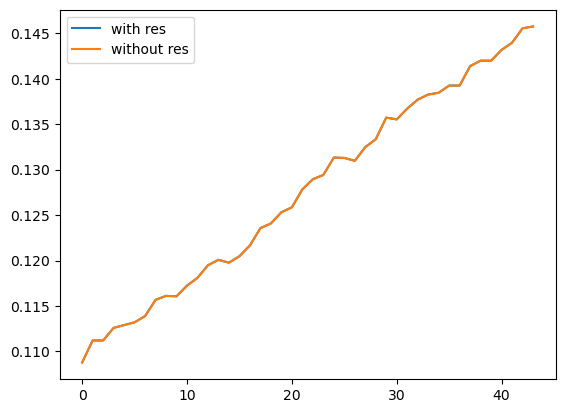

In [11]:
# see if residual layer is actually doing anything computaionally
from plots.plot_utils import load_pickle

pkl_w_res = load_pickle("boston_lossscaled_batch_cal_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl")
pkl_wo_res = load_pickle("boston_lossscaled_batch_cal_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl")
from matplotlib import pyplot as plt

plt.plot(pkl_w_res['te_ece_controlled'], label='with res')
plt.plot(pkl_wo_res['te_ece_controlled'], label='without res')
plt.legend()

In [9]:
from plots.plot_utils import load_pickle
import matplotlib.pyplot as plt
import os
result_prefix = os.path.join(os.environ['SCRATCH'], 'results', 'lump')
dataset = 'concrete'
hyper = 'nl-1_hs-32'

pkl_maqr = load_pickle(os.path.join(result_prefix, dataset, hyper, f"{dataset}_lossmaqr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace('-', '')}_1.pkl"))
pkl_qr = load_pickle(os.path.join(result_prefix, dataset, hyper, f"{dataset}_lossbatch_qr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace('-', '')}_1.pkl"))
# concrete_lossmaqr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_1.pkl

Text(0.5, 1.0, 'Test ECE vs Sharpness')

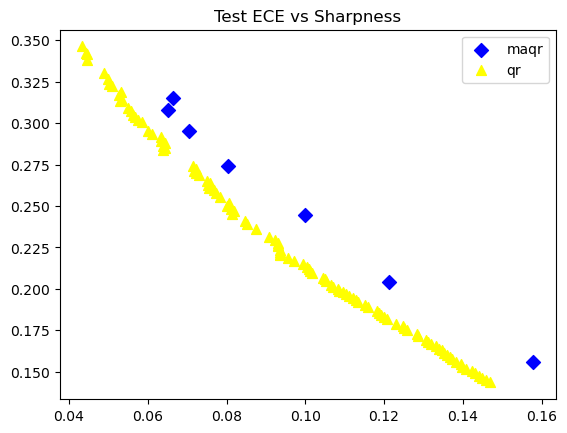

In [14]:
plt.scatter(pkl_maqr['te_ece_controlled'], pkl_maqr['te_sharp_score_controlled'], label='maqr', marker='D', color='blue', s=50)
plt.scatter(pkl_qr['te_ece_controlled'], pkl_qr['te_sharp_score_controlled'], label='qr', marker='^', color='yellow', s=50)
plt.legend()
plt.title('Test ECE vs Sharpness')


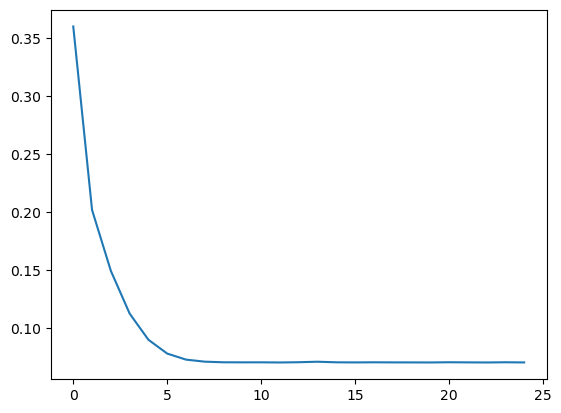

In [10]:
plt.plot(pkl_maqr['tr_loss_list'], label='maqr')

# Datasets

In [1]:
# transfer csv into space separated

with open('data/datasets/Features_TestSet.csv', 'r') as f:
    test_lines = f.readlines()

with open('data/datasets/Features_Variant_2.csv', 'r') as f:
    train_lines = f.readlines()

with open('data/datasets/facebook_train.txt', 'w') as f:
    for line in train_lines:
        f.write(' '.join(line.strip().split(',')) + '\n')

with open('data/datasets/facebook_test.txt', 'w') as f:
    for line in test_lines:
        f.write(' '.join(line.strip().split(',')) + '\n')


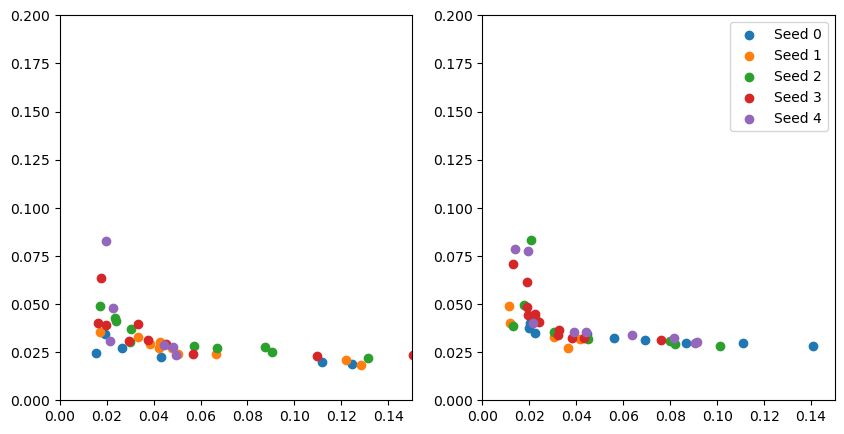

In [1]:
import matplotlib.pyplot as plt
import os
from plots.plot_utils import load_pickle
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
method = 'batch_cal'
hyper = 'nl-8_hs-256'
for i, method in enumerate(['batch_cal', 'batch_qr']):
    plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f"naval/{hyper}/naval_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace('-', '')}_0.pkl")
    plt_seeds = [plt_seed.replace("_0.pkl", f"_{i}.pkl") for i in range(5)]
    datas = [load_pickle(pkl) for pkl in plt_seeds]
    for j, data in enumerate(datas):
        axes[i].scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"Seed {j}")
        axes[i].set_xlim(0, 0.15)
        axes[i].set_ylim(0, 0.2)
plt.legend()

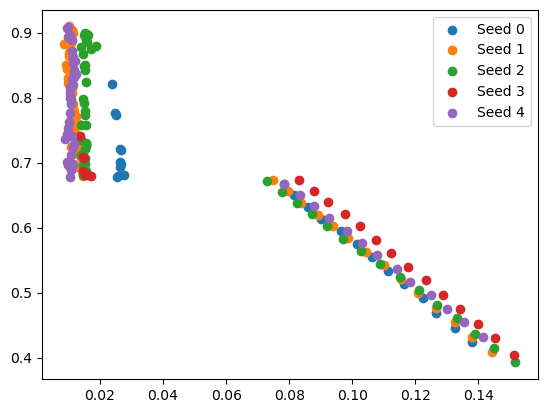

In [7]:

import matplotlib.pyplot as plt
import os
from plots.plot_utils import load_pickle
method = 'batch_qr'
plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f'naval/nl-1_hs-32/naval_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl')
plt_seeds = [plt_seed.replace("_0.pkl", f"_{i}.pkl") for i in range(5)]
datas = [load_pickle(pkl) for pkl in plt_seeds]
for i, data in enumerate(datas):
    plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"Seed {i}")
plt.legend()

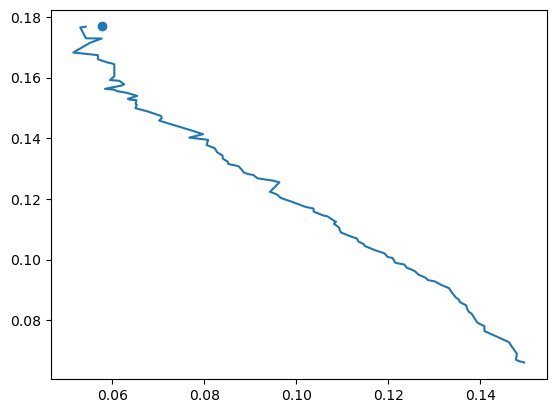

In [8]:
from plots.plot_utils import load_pickle
import matplotlib.pyplot as plt
test_pkl = 'boston_lossscaled_batch_cal_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'

data = load_pickle(test_pkl)

plt.plot(data['te_ece_controlled'], data['te_sharp_score_controlled'], label='controlled')
plt.scatter(data['te_ece'], data['te_sharp_score'], label='uncontrolled')

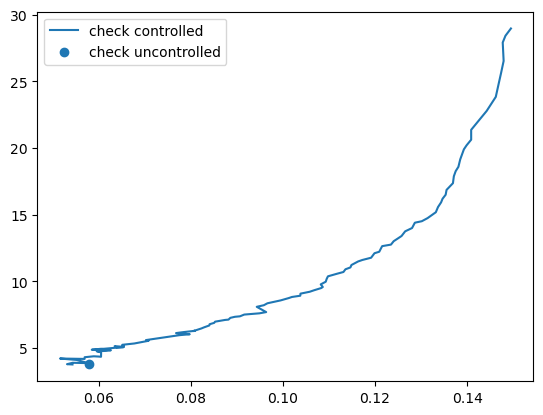

In [9]:
plt.plot(data['te_ece_controlled'], data['te_bag_nll_controlled'], label='check controlled')
plt.scatter(data['te_ece'], data['te_bag_nll'], label='check uncontrolled')
plt.legend()

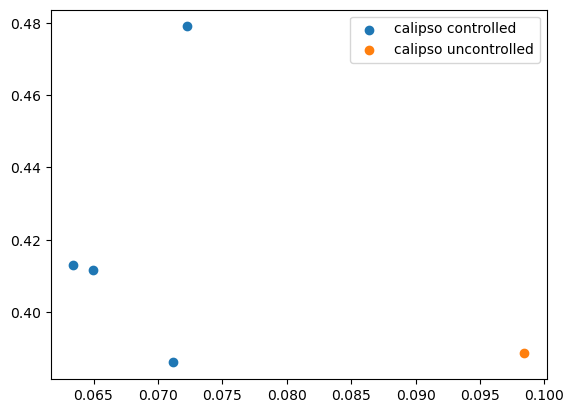

In [2]:
from plots.plot_utils import load_pickle
calipso_pkl = 'boston_losscalipso_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
calipso_data = load_pickle(calipso_pkl)
import matplotlib.pyplot as plt
plt.scatter(calipso_data['te_ece_controlled'], calipso_data['te_sharp_score_controlled'], label='calipso controlled')
plt.scatter(calipso_data['te_ece'], calipso_data['te_sharp_score'], label='calipso uncontrolled')
plt.legend()

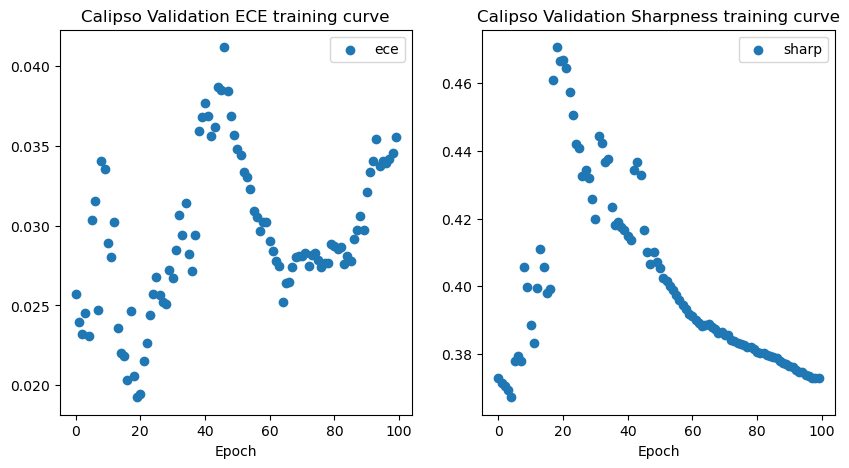

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(range(len(calipso_data['va_ece_list'])), calipso_data['va_ece_list'], label='ece')
axes[1].scatter(range(len(calipso_data['va_sharp_list'])), calipso_data['va_sharp_list'], label='sharp')
axes[0].set_xlabel('Epoch')
axes[0].set_title('Calipso Validation ECE training curve')
axes[0].legend()

axes[1].set_xlabel('Epoch')
axes[1].set_title('Calipso Validation Sharpness training curve')
axes[1].legend()

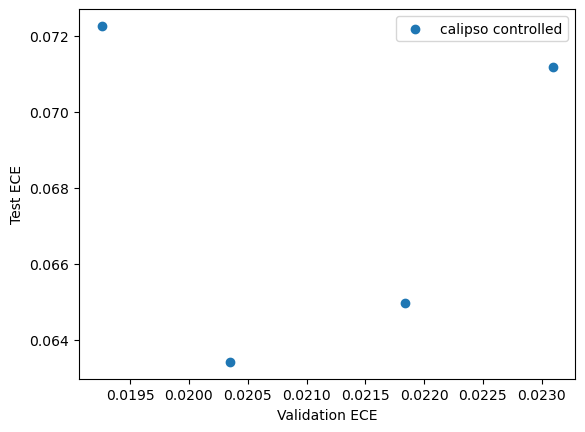

In [9]:
import numpy as np
plt.scatter(calipso_data['va_ece_controlled'], calipso_data['te_ece_controlled'], label='calipso controlled')
plt.xlabel('Validation ECE')
plt.ylabel('Test ECE')
plt.legend()

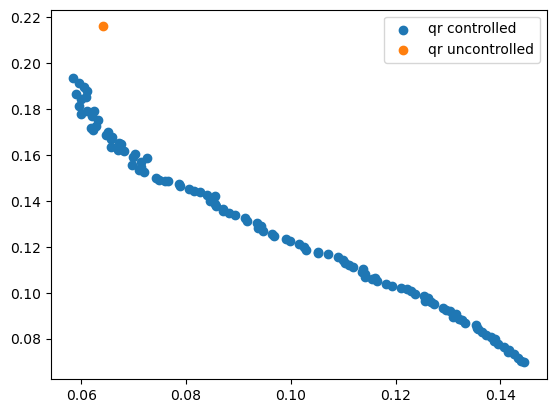

In [21]:
from plots.plot_utils import load_pickle
batch_qr_pkl = 'boston_lossbatch_qr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
qr_data = load_pickle(batch_qr_pkl)
import matplotlib.pyplot as plt
plt.scatter(qr_data['te_ece_controlled'], qr_data['te_sharp_score_controlled'], label='qr controlled')
plt.scatter(qr_data['te_ece'], qr_data['te_sharp_score'], label='qr uncontrolled')
plt.legend()

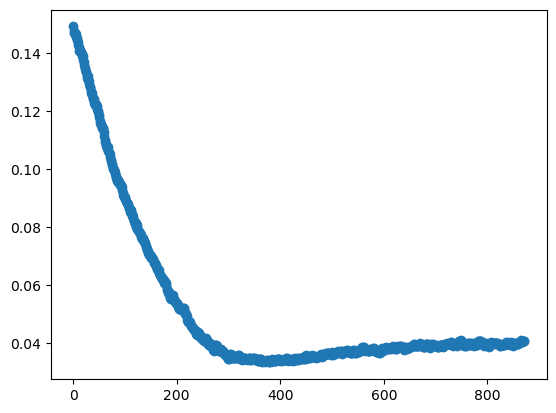

In [22]:
plt.scatter(range(len(qr_data['va_ece_list'])), qr_data['va_ece_list'], label='calipso ece')